# Modelling

Here I forecast the number of pickups happenning in a block throughout the three months given its socioeconomic factors. After analysing the dataset I concluded that it makes sense to use **Multiple Linear Regression** after applying a **log transformation** to the target variable (number of pickups)

We are restricted to only use the socioeconomic factors, but we would surely lower the RSME prediction error by adding more features from the original taxi dataset

## Loading the data

In [2]:
import pandas as pd, numpy as np
import geopandas as gpd

In [ ]:
# Polygons of blocks in New York.
nymap = gpd.read_file("./taxi/nyc_cbg_geoms.geojson")
nymap["geoid"] = nymap["geoid"].astype(np.int64)

#socioeconomic data
acs = pd.read_csv("./taxi/nyc_acs_demographics.csv", dtype = {"geoid" : np.int64}, index_col=0)

#number of pickups per block
pickup_counts = pd.read_csv("./files/pickup_counts.csv", index_col = 0)

First we build a pivot table from the acs data.

In [16]:
block_acs = acs.pivot(index = "geoid", columns = "acs_demog_var" ).droplevel(level = 0, axis = 1)
pct_nan = block_acs.isna().sum()/6339*100 #percentage of nan

Listed below are the features which have missing values (see percentage).

We will drop ```aggregate_travel_time_to_work``` and ```owner_occupied_housing_units_median_value``` since they have  94% and 28%. But regarding the rest of the features with missing values we will try to input data from surrounding blocks

In [8]:
pct_nan[pct_nan > 0]

acs_demog_var
aggregate_travel_time_to_work                                  94.289320
income_per_capita                                               1.151601
median_age                                                      1.056949
median_income                                                   7.335542
median_rent                                                     8.834201
median_year_structure_built                                     1.577536
owner_occupied_housing_units_median_value                      28.127465
renter_occupied_housing_units_paying_cash_median_gross_rent     8.392491
dtype: float64

## Inputting missing data from neighbor blocks
We could input each feature's median or the average value on Nans, but we can do better if we just take the values of the neighbor blocks, which will **more likely be similar** to the current missing one. To find each blocks´s neighbors we just slightly scale up all the block polygons and find which ones intersect.

In [9]:
nymap_scaled = nymap.copy()
nymap_scaled["geometry"] = nymap_scaled["geometry"].scale(xfact = 1.2,yfact = 1.2, origin = "center")


In [163]:
#took a while to compute this. Does not scale.
neigbors_df  = pd.DataFrame(index = nymap_scaled["geoid"], columns = nymap_scaled["geoid"])
from itertools import combinations
for x,y in combinations(nymap_scaled.values, 2):
    x_geoid, x_polygon = x
    y_geoid, y_polygon = y
    is_neighbor = x_polygon.intersects(y_polygon)
    neigbors_df.loc[x_geoid][y_geoid] = is_neighbor
    neigbors_df.loc[y_geoid][x_geoid] = is_neighbor

# We fill the Nan in the diagonal with False (intersection of block with itself) to avoid problems
neigbors_df.fillna(False, inplace = True) 

In [15]:
#neigbors_df.to_csv("neighbor_blocks_1.2.csv")
neigbors_df = pd.read_csv("./neighbor_blocks_1.2.csv", index_col=0)

In [10]:
def input_from_neighbors(df, columns_to_input, neighbor_matrix):
    data = df.copy()
    for column_name in columns_to_input:
        #We find which rows are misisng values 
        rows_missing_values = data[data[column_name].isna()].index
        for geoid in rows_missing_values:
            neighbors = neighbor_matrix[str(geoid)] #we search for neighbors of geoid
            mean_value_neighbors = data[column_name][neighbors].mean() #we compute here the mean of neighbors
            data.loc[geoid][column_name] = mean_value_neighbors
    return data


In [20]:
columns_to_input = ["income_per_capita","median_age", "median_income","median_rent", "median_year_structure_built", "renter_occupied_housing_units_paying_cash_median_gross_rent"]
block_acs = input_from_neighbors(block_acs, columns_to_input , neigbors_df)

In [21]:
# Drops features and checks that no longer are there missing values
block_acs.drop(["aggregate_travel_time_to_work", "owner_occupied_housing_units_median_value"], axis = 1, inplace = True)
block_acs.isna().sum().sum()

0

## Transforming variables

We will replace the target variable with its logarithm. This increases the explained variance of our linear model since the relationship becomes more linear.

In [22]:
pickups_per_day_per_block = pd.read_csv("./files/pickups_per_day_per_block.csv", index_col=0)
pickup_counts = pickups_per_day_per_block["total"]

In [106]:
model_data = pd.merge(block_acs,pickup_counts, right_index = True, left_index = True, how = "inner" )

model_data.rename(columns = {"total" : "target",
                             "renter_occupied_housing_units_paying_cash_median_gross_rent" : "renter_cash_payers"
                            }, inplace = True)


In [26]:
from matplotlib import pyplot as plt
import seaborn as sns

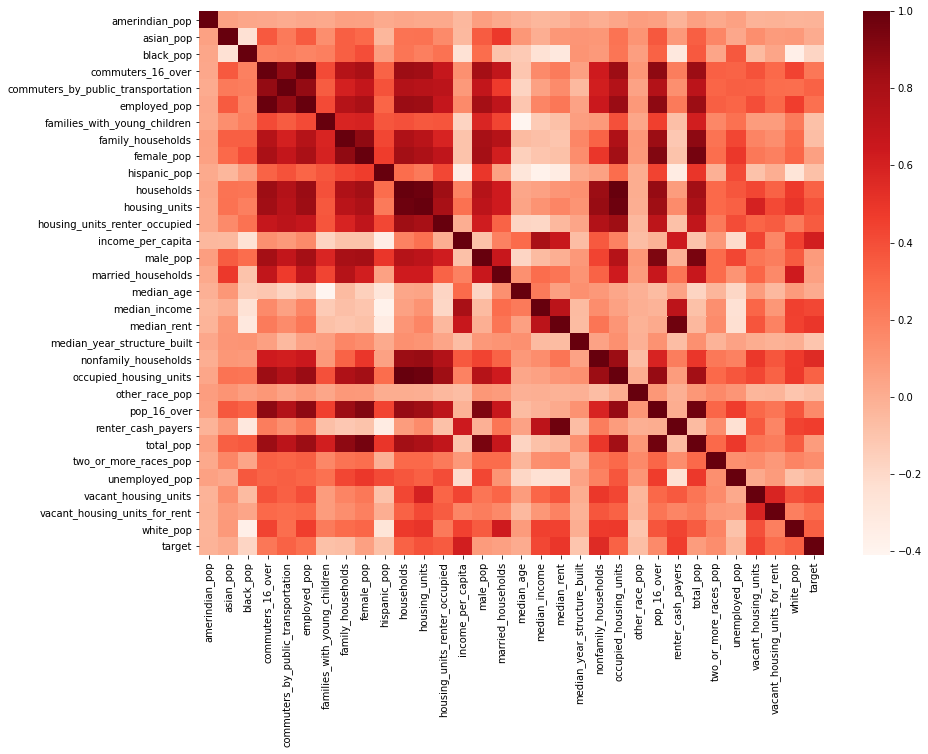

In [27]:
plt.figure(figsize=(14,10))
cor = model_data.corr()
sns.heatmap(cor, annot=False, cmap=plt.cm.Reds)
plt.show()

If we take a look at the features which are most highly correlated with our target we appreciate some linearity in the scatterplots. 

In [28]:
corr_target = np.abs(cor["target"]).sort_values(ascending = False)
print(corr_target.head(6))

target                  1.000000
income_per_capita       0.618181
nonfamily_households    0.549863
median_rent             0.498544
renter_cash_payers      0.461574
vacant_housing_units    0.436983
Name: target, dtype: float64


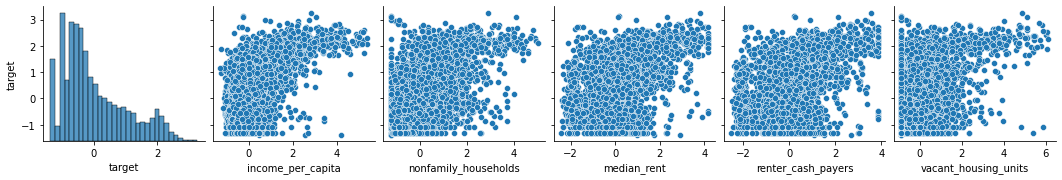

In [370]:
top_5 = corr_target.index[:6]

sns.pairplot(
    model_data_std,
    y_vars=["target"],
    x_vars = top_5
)

In [30]:
import statsmodels.api as sm

In [170]:
from sklearn.preprocessing import StandardScaler
from  sklearn.model_selection import train_test_split 
from scipy import stats

def data_preparation(input_data, remove_outliers = True, target_to_log = True):
       
    model_data = input_data.copy()
    # Transforming the target with log
    if target_to_log:
        model_data["target"] =  np.log10(model_data["target"])
        
    # Scaling the data
    scl = StandardScaler()
    model_data_std = scl.fit_transform(model_data)
    model_data_std = pd.DataFrame(model_data_std, columns= model_data.columns, index = model_data.index)

    #Removing outliers
    if remove_outliers:
        model_data_std = model_data_std[(np.abs(stats.zscore(model_data)) < 3).all(axis = 1)]

    X = model_data_std.drop(["target"], axis = 1)
    y = model_data_std["target"]
    
    return X, y, scl

## Fitting the model

In [171]:
X, y , scl = data_preparation(model_data)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 33)

In [172]:
model = sm.OLS(y,X)
ols_res = model.fit()
print(ols_res.summary())

                                 OLS Regression Results                                
Dep. Variable:                 target   R-squared (uncentered):                   0.616
Model:                            OLS   Adj. R-squared (uncentered):              0.613
Method:                 Least Squares   F-statistic:                              283.0
Date:                Thu, 08 Oct 2020   Prob (F-statistic):                        0.00
Time:                        22:50:37   Log-Likelihood:                         -3981.9
No. Observations:                4798   AIC:                                      8018.
Df Residuals:                    4771   BIC:                                      8193.
Df Model:                          27                                                  
Covariance Type:            nonrobust                                                  
                                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------

## Checking if the model complies with the linear regression assumptions


### Normality
We check if the residuals are normally distributed by drawing a qqplot. We see that that most of the residuals behave normally (excepting those for high and low values)

In the other hand, the Jarque Bera test is giving us a very high value, which means that the residuals might not be normal.

[('Jarque-Bera', 433.45450086808603),
 ('Chi^2 two-tail prob.', 7.525772027517247e-95),
 ('Skew', 0.5116774953294632),
 ('Kurtosis', 4.272585203269324)]

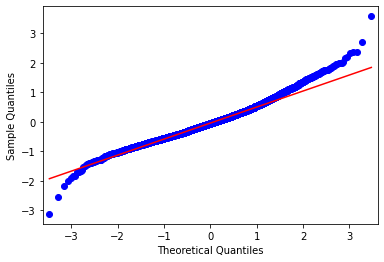

In [41]:
from statsmodels.stats.stattools import jarque_bera
from statsmodels.graphics.gofplots import qqplot

predictions = ols_res.predict(X_train)
residuals = y_train - predictions

qqplot(residuals, line = 'q')
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = jarque_bera(residuals)
list(zip(name,test))

### Homoscedasticity
The residuals should have constant variance across the feature space. We can see that it is not the case since the shape of the scatterplot is moreless conic.

/Users/juanluisrto/opt/anaconda3/envs/carto/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

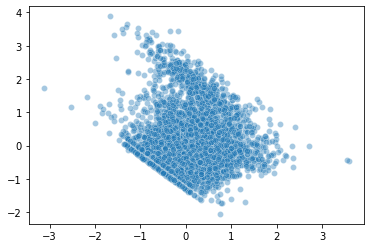

In [444]:
sns.scatterplot(residuals, predictions, alpha = 0.4)


### Multicollinearity and autocorrelation
The condition number of the coefficient matrix is a good measure of multicollinearity. In our case it has a very high value, which indicates that multicollinearity is unfortunately present

The Durbin-Watson test is 1.2, which indicates 

In [461]:
np.linalg.cond(ols_res.model.exog)

3.945318408076205e+16

## Interpretation of the results and conclusions

After testing with several algorithms (RandomForest, GaussianRegressor) I chose a linear regression model, since it was giving the best R^2 metric and had the lowest RSME of the models.

We have an $R^2$ value of 0.65, which explains a fair amount of variability in the dataset. However we have realised that our data complies does not follow very well he assumptions of linear regression, which might result on bad predictions.

To solve these problems we could try to apply some more linear transformations to some of the features.
Of course, using some other features from the taxi dataset would surely have a positive impact

## Output the model estimations

In [188]:
def reverse_transformation(X, scl, pred = None):
    standard_matrix = pd.DataFrame(X)
    if pred is not None:
        standard_matrix["target"] = pred
    original_matrix = scl.inverse_transform(standard_matrix) # we destandarized the data
    log_pickups = original_matrix[:,-1] # We select the last column
    original_pickups = np.power(10, log_pickups) # We invert the log transformation
    rounded_pickups = np.round(predicted_pickups, decimals = 0).astype(np.int64)
    return rounded_pickups

In [173]:
X_pred, y_pred, scl_pred = data_preparation(model_data, remove_outliers=False)
pred = ols_res.predict(X_pred)

In [189]:
predicted_pickups = reverse_transformation(X_pred, scl_pred, pred = pred)
#original_pickups = reverse_transformation(X_pred, scl_pred)

In [ ]:
sns.histplot(pred_pickups_df)

In [195]:
pred_pickups_df = pd.DataFrame(predicted_pickups, index = y_pred.index, columns = ["pred_pickups"])
pred_pickups_df.to_csv("./files/pred_pickups.csv")